<center>
    <h3>Pattern Recognition Lab</h3>
    <hr>
    <br>
    <div style="margin:0 60px 0px 0">
        <img src="https://www5.cs.fau.de/images/lme.jpg" alt="PA" width=150px align=center>
    </div>
    <h1>Style Classification in Posters</h1>
    <h2>Deep Learning Pipeline</h2>
    <hr>
    <h3>Tim Löhr</h3>
    <br>
</center>

>  
      - Style classification using WikiArt
      - Crawl WikiArt (images+styles)
      - Train DL-based network w. WikiArt data
      - Apply to poster data
      
>
      - Transformationen (kornia)
      - pytorch lightning
      - weight decay
      - efficient net or dense net

**Table of Contents** `(clickable)`
- [1.0 - Data Loading](#1)
- [2.0 - Balance DataFrame](#2)
    - [2.1 - Label Mapping](#2.1)
    - [2.2 - Imbalance Splitting](#2.2)
- [3.0 - Check Label Distribution Comparison](#3)
- [4.0 - Save train and test set](#4)
- [5.0 - Visualize Dataset](#5)

<a name='0'></a>

## (0) Load Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys

import torch
import torchvision

import kornia as K
from kornia.augmentation import AugmentationBase

sys.path.insert(0, '../Scripts')
from utils import *
from data import WikiartDataset
from trainer import Trainer

import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

<a name='1'></a>

## (1) Data Loading

In [2]:
csv_path = os.path.join("..", "..", "Data", "wikiart.csv")
img_path = os.path.join("..", "..", "Imgs")
root_dir = os.path.join("..", "..", "Data", "wikiart", "images")
train_dir = os.path.join("..", "..", "Data", "train.csv")
test_dir = os.path.join("..", "..", "Data", "test.csv")
labels_dir = os.path.join("..", "..", "Data", "labels.csv")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(csv_path)
print(f"DataFrame Shape: {df.shape}")
print(device)

DataFrame Shape: (23205, 5)
cpu


In [3]:
features = ['artistName', 'genre', 'tags', 'path']
label = 'style'
max_occurence = 280

train_styles = df[label].value_counts()[df[label].value_counts() >= max_occurence]
drop_styles = df[label].value_counts()[df[label].value_counts() < max_occurence]

train_sum = np.sum(train_styles)
drop_sum = np.sum(drop_styles)

In [4]:
cleaned_df = df[~df[label].isin(drop_styles.index)]

print(f"Before removing lower than {max_occurence} styles: Shape: {df.shape}")
print(f"After removing lower than {max_occurence} styles: Shape: {cleaned_df.shape}")
print(f"{drop_sum} rows dropped")

assert len(df) - drop_sum == len(cleaned_df) 

Before removing lower than 280 styles: Shape: (23205, 5)
After removing lower than 280 styles: Shape: (16838, 5)
6367 rows dropped


<a name='2'></a>

## (2) Balance DataFrame

In [5]:
g = cleaned_df.groupby(label, group_keys=False)
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)
factorizer, labels = pd.factorize(balanced_df['style'])
balanced_df['style'] = factorizer
print(balanced_df.shape)

(5620, 5)


<a name='2.1'></a>

### (2.1) Label Mapping

In [6]:
labels_df = pd.DataFrame(labels, np.arange(len(labels)))
labels_df = labels_df.rename(columns={0: "Factorized"})
labels_df.to_csv(labels_dir)

<a name='2.2'></a>

### (2.2) Imbalance Splitting

In [7]:
train_x = balanced_df['path']
train_y = balanced_df['style']
groups = balanced_df['artistName']

distrs = []
index = []

for fold_ind, (train_ind, test_ind) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    train_y, test_y = train_y[train_ind], train_y[test_ind]
    train_groups, test_groups = groups[train_ind], groups[test_ind]
    
    assert len(set(train_groups) & set(test_groups)) == 0
    
    distrs.append(get_distribution(train_y))
    index.append(f'Train set')
    
    distrs.append(get_distribution(test_y))
    index.append(f'Test set')
    break

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=labels)

'Distribution per class:'

,Abstract Expressionism,Art Informel,Art Nouveau (Modern),Baroque,Cubism,Early Renaissance,Expressionism,High Renaissance,Impressionism,Mannerism (Late Renaissance),Neoclassicism,Northern Renaissance,Op Art,Pop Art,Post-Impressionism,Realism,Rococo,Romanticism,Surrealism,Symbolism
Train set,4.58%,5.69%,3.49%,5.54%,5.67%,4.12%,5.67%,6.48%,6.15%,3.64%,5.59%,2.45%,6.25%,5.67%,4.07%,5.67%,4.73%,5.67%,6.05%,2.81%
Test set,6.00%,3.36%,8.57%,3.72%,3.42%,7.07%,3.42%,1.50%,2.28%,8.21%,3.60%,11.03%,2.04%,3.42%,7.19%,3.42%,5.64%,3.42%,2.52%,10.19%


In [8]:
X_train = balanced_df.iloc[train_ind]
X_test = balanced_df.iloc[test_ind]

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

assert X_train.shape[0] + X_test.shape[0] == balanced_df.shape[0]
assert X_train['artistName'].nunique() + X_test['artistName'].nunique() == balanced_df['artistName'].nunique()

Train: (3952, 5)
Test: (1668, 5)


In [9]:
g = X_test.groupby(label, group_keys=False)
X_test = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)
print(f"New Test: {X_test.shape}")

New Test: (500, 5)


<a name='3'></a>

## (3) Check Label Distribution Comparison

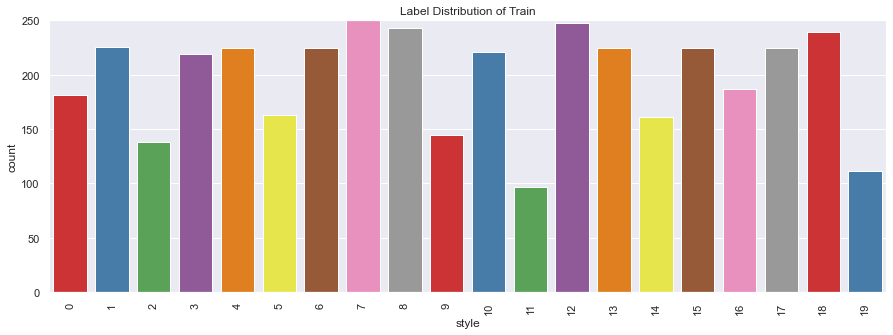

In [10]:
plt.figure(figsize=(15,5))
chart = sns.countplot(
    data=X_train,
    x='style',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Label Distribution of Train")
plt.ylim(0, 250)
plt.show()

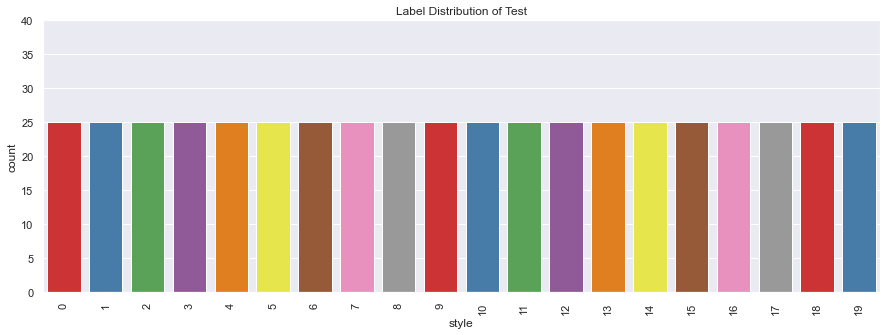

In [11]:
plt.figure(figsize=(15,5))
chart = sns.countplot(
    data=X_test,
    x='style',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Label Distribution of Test")
plt.ylim(0, 40)
plt.show()

<a name='4'></a>

## (4) Save train and test set

In [18]:
X_train['style'].nunique()

20

In [13]:
try:
    X_train = pd.read_csv(train_dir)
    X_test = pd.read_csv(test_dir)
    print(f"Train and Test successfully loaded.")
    
except:
    X_train.to_csv(train_dir, index=False)
    X_test.to_csv(test_dir, index=False)
    print(f"Train and Test successfully saved.")
    
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Train and Test successfully saved.
X_train: (3952, 5)
X_test: (500, 5)


<a name='5'></a>

## (5) Visualize Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


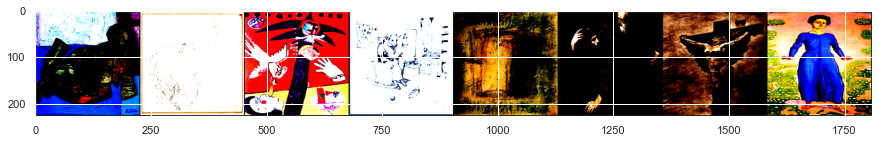

In [14]:
trainloader = torch.utils.data.DataLoader(WikiartDataset(train_dir, root_dir, 'train'), batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(WikiartDataset(test_dir, root_dir, 'val'), batch_size=8, shuffle=True)

dataiter = iter(trainloader)
data = next(dataiter)

plt.figure(figsize=(15,5))
plt.imshow(torchvision.utils.make_grid(data[0], nrow=32).permute(1, 2, 0))
plt.show()

In [15]:
import kornia.augmentation as K
import torch.nn as nn

transform = nn.Sequential(
   K.Normalize(torch.Tensor([0.485, 0.456, 0.406]), torch.Tensor([0.229, 0.224, 0.225])),
   K.RandomAffine(360),
   K.ColorJitter(0.2, 0.3, 0.2, 0.3),
   K.CenterCrop(int(np.random.randint(180, 224, size=(1))[0])),
   K.RandomHorizontalFlip(0.5),
   K.RandomVerticalFlip(0.5),
)

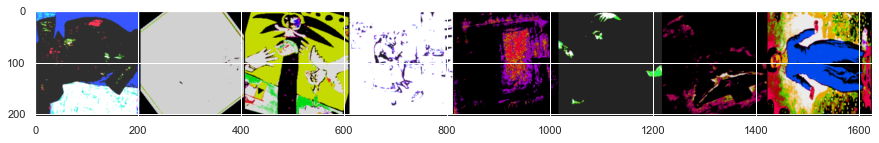

In [16]:
transform(data[0])

plt.figure(figsize=(15,5))
plt.imshow(torchvision.utils.make_grid(transform(data[0]), nrow=32).permute(1, 2, 0))
plt.show()